## 1. Module Import, Select Device, and Download MNIST Data

### 1-1. Setup & Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# from torchsummary import summary

import qiskit
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

### 1-2. Select Device

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
print('cuda index:', torch.cuda.current_device())
print('GPU 이름:', torch.cuda.get_device_name())

Using PyTorch version: 1.7.1  Device: cuda
cuda index: 0
GPU 이름: GeForce RTX 3070


### 1-3. Setting of the main hyper-parameters of the model

In [3]:
BATCH_SIZE = 256
EPOCHS = 10     # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

### 1-4. Data Loading

In [43]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100.1%Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
113.5%Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
100.4%Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
180.4%Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [44]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


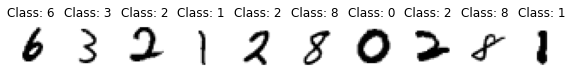

In [45]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))



## 2. Construct Quantum Circuit

### 2-1. Create a 'Quantum Class' with Qiskit

In [6]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, filter_size, backend, shots, threshold):
        # --- Circuit definition start ---
        self.n_qubits = filter_size ** 2
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        self._circuit.barrier()
        self._circuit += random_circuit(self.n_qubits, 2)
        self._circuit.measure_all()
        # --- Circuit definition end ---

        self.backend   = backend
        self.shots     = shots
        self.threshold = threshold

    def run(self, data):
        # val > self.threshold  : |1> - rx(pi)
        # val <= self.threshold : |0> - rx(0)
        thetas = []
        for dat in data:
            theta = []
            for val in dat:
                if val > self.threshold:
                    theta.append(np.pi)
                else:
                    theta.append(0)
            thetas.append(theta)
        
        param_dict = dict()

        for theta in thetas:
            for i in range(self.n_qubits):
                param_dict[self.theta[i]] = theta[i]

        param_binds = [param_dict]
        print(param_binds)

        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots, 
                             parameter_binds = param_binds)
        result = job.result().get_counts(self._circuit)

        counts = 0
        for key, val in result.items():
            cnt = sum([int(char) for char in key])
            counts += cnt * val

        # Compute probabilities for each state
        probabilities = counts / self.shots
        
        return np.array([probabilities])

Let's test the implementation.

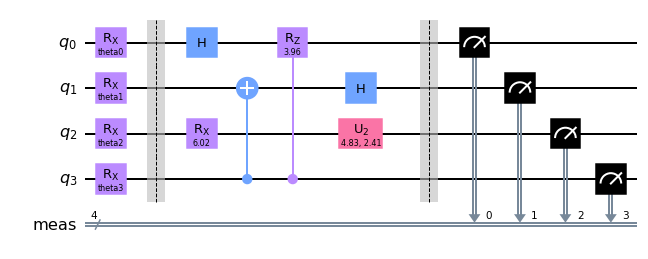

In [11]:
backend = qiskit.Aer.get_backend('qasm_simulator')
filter_size = 2
circ = QuanvCircuit(filter_size, backend, 100, 127)
data = torch.tensor([0, 0, 0, 255])

# circ.run(data)

circ._circuit.draw(output='mpl')

### 2-2. Create a 'Quanvolution Class' with PyTorch

In [12]:
def quanv_feed(image):
    """
    Convolves the input image with many applications 
    of the same quantum circuit.

    In the standard language of CNN, this would correspond to
    a convolution with a 5×5 kernel and a stride equal to 1.
    """
    out = np.zeros((24, 24, 25))

    # Loop over the coordinates of the top-left pixel of 5X5 squares
    for j in range(24):
        for k in range(24):
            # Process a squared 5x5 region of the image with a quantum circuit
            circuit_input = []
            for a in range(5):
                for b in range(5):
                    circuit_input.append(image[j + a, k + b, 0])
            q_results = circuit(circuit_input)

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(25):
                out[24, 24, c] = q_results[c]
    return out

In [15]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(quanv_feed(input.tolist())))
        result = torch.tensor(expectation_z)
        
        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output): # 확인 필요(검증 x)
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, filter_size, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuanvCircuit(filter_size = 5, backend = backend, shots = shots, threshold = 127)
        self.shift = shift
        
    def forward(self, input):
        return QuanvFunction.apply(input, self.quantum_circuit, self.shift)


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(kernel_size=5, backend = qiskit.Aer.get_backend('qasm_simulator'), shots = 100, shift = np.pi / 2) # <- Quanv!!!!
        self.conv = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.quanv(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)